In [1]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 指定文件夹路径
exception_save_path = '../Dataset/Exception_Data'

# 获取文件夹下的所有文件名称
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

download_save_path = 'E:/Dataset/wind_shear/Data_Download'
download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]

In [2]:
# give the preset classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "SPLY", "ABRK", "BPGR_1", "BPGR_2", "BPYR_1", "BPYR_2", "MSQT_1", "MSQT_2", "NSQT", "BLV", "CALT", "PACK", "WOW", 
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", 
                       "TH", "MH", "TAS", "CASM", "GS", "IVV",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = ["N2_1", "N2_2", "N2_3", "N2_4",
                   "ECYC_1", "ECYC_2", "ECYC_3", "ECYC_4", "EHRS_1", "EHRS_2", "EHRS_3", "EHRS_4", "VIB_1", "VIB_2", "VIB_3", "VIB_4", "FADS", "HYDG", "HYDY",
                   "N1_1", "N1_2", "N1_3", "N1_4", "N1T", "FF_1", "FF_2", "FF_3", "FF_4", "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIP_1", "OIP_2", "OIP_3", "OIP_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL", "EGT_1", "EGT_2", "EGT_3", "EGT_4",
                   "LGDN", "LGUP"]
var_group_control = ["CRSS", "HDGS", "A_T", "APFD", "DFGS", "FGC3", "PUSH", "PTRM", "TCAS",
                     "ILSF", "RUDP", "CCPC", "CCPF", "CWPC", "CWPF", "PLA_1", "PLA_2", "PLA_3", "PLA_4",
                     "SNAP", "TMODE", "EAI", "TAI", "WAI_1", "WAI_2", 
                     "APUF", "FADF", "FIRE_1", "FIRE_2", "FIRE_3", "FIRE_4", "GPWS", "MW", "POVT", "SHKR", "SMOK", "TOCW"]
var_group_external = ["ALT", "ALTR", "WS", "WD", "PI", "PS", "PT", "SAT", "TAT",
                      "DA", "TRK", "TRKM", "LOC", "LATP", "LONP"]
var_group_recorder = ["DWPT", "PH", 
                     "ACMT", "FRMC", "GMT_HOUR", "GMT_MINUTE", "GMT_SEC"]
var_group_unclassified = ["ATEN", "EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "LMOD", "VMODE", "MACH", "MNS", "MRK", "N1C", "N1CO", "SMKB", "VAR_1107", "VAR_2670", "VAR_5107", "VAR_6670"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_group in var_dict.items():
        group_lens_dict[group_name] = len(var_group)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

# 查找给定变量名称对应的总序数
def find_var_idx(var_name, var_dict):
    count = 0
    for var_list in var_dict.values():
        if var_name in var_list:
            count += var_list.index(var_name)
            return(count)
        else:
            count += len(var_list)

mechanism: 38
power: 47
control: 37
external: 15
recorder: 7
unclassified: 19

163 variables in total


In [3]:
from sklearn.preprocessing import StandardScaler

def dataSampling(var_data, var_rate, wshr_data):
    # 对每个变量按照rate进行下采样或过采样，对长为n+1的数据，抓取前n个全变量为输入，后n个有缺变量为输出
    if var_rate == 1:
        sampling_data = var_data
    else: # 进行重采样
        sampling_data = [var_data[i] for i in np.linspace(0, len(var_data)- 1, len(wshr_data), dtype=int)]
    # # 将采样数据进行min_max归一化
    # if (np.max(sampling_data) - np.min(sampling_data)) > 1e-5:
    #     sampling_data = (sampling_data - np.min(sampling_data)) / (np.max(sampling_data) - np.min(sampling_data))
    # else:
    #     sampling_data = sampling_data
    return sampling_data

def dataConstruct(work_folder_path, work_mat_name, variable_list, normalized = False, is_all_variable = False):
    # 读取工作mat
    work_mat = loadmat(os.path.join(work_folder_path, work_mat_name))

    # 初始化采样数据list
    sampling_data_list = []
    wshr_data = work_mat["WSHR"][0][0][0]

    if not is_all_variable:
        # 提取variable_list变量并进行重采样
        for var_name in variable_list:
            var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
            sampling_data = dataSampling(var_data, var_rate, wshr_data)
            # print(np.max(sampling_data), np.min(sampling_data))
            sampling_data_list.append(sampling_data)
    else:
        for var_list in var_groups_dict.values():
            for var_name in var_list:
                var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
                sampling_data = dataSampling(var_data, var_rate, wshr_data)
                # print(np.max(sampling_data), np.min(sampling_data))
                sampling_data_list.append(sampling_data)
        sampling_data_list = np.squeeze(np.array(sampling_data_list))

    # 生成解释变量X和分类变量Y
    X = np.squeeze(np.array(sampling_data_list)).T
    Y = np.array(wshr_data).reshape(-1,1)
    if normalized:
        # 数据标准化
        s_scaler = StandardScaler()
        X = s_scaler.fit_transform(X)

    wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
    # print(X.shape, Y.shape)
    print(f"Wind Shear Warns at time {wshr_class_idx[0]}")

    # if not is_all_variable:
    #     # 绘制X的时间变化
    #     plt.figure()
    #     for i, var_name in enumerate(variable_list):
    #         plt.plot(range(len(wshr_data)), X[:, i], label=var_name)
    #     plt.plot(range(len(wshr_data)), Y, c='red', label='Wind Shear Warning')
    #     plt.xlabel('time(s)')
    #     plt.ylabel('WS/WD/TAS & WSHR')
    #     plt.title('Normalized WS/WD/TAS and WSHR')
    #     plt.legend()
    #     # if np.std(X[:, 2]) > 1e-1:
    #     #     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
    #     plt.show()

    #     # 绘制X的三维散点图
    #     fig = plt.figure(figsize=(5, 5))
    #     ax = fig.add_subplot(111, projection='3d')
    #     ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
    #     ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 50, label='WSHR = 0')
    #     ax.set_xlabel(variable_list[0])
    #     ax.set_ylabel(variable_list[1])
    #     ax.set_zlabel(variable_list[2])
    #     ax.legend()
    #     plt.tight_layout()
    #     plt.show()

    return X, Y

In [30]:
work_mat = loadmat(os.path.join(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2]))
for var in ['TAS', 'WS', 'WD', 'PTCH', 'ALT', 'ALTR', 'PT']:
    data = work_mat[var]
    print(data[0][0][2])

['KNOTS']
['KNOTS']
['DEG']
['DEG']
['FEET']
['FT/MIN']
['MB']


Wind Shear Warns at time [938 939 940 941 942 943]


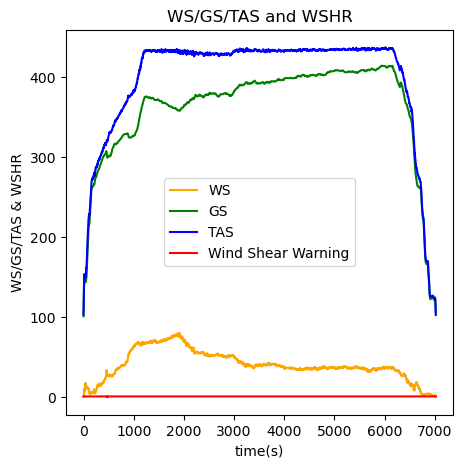

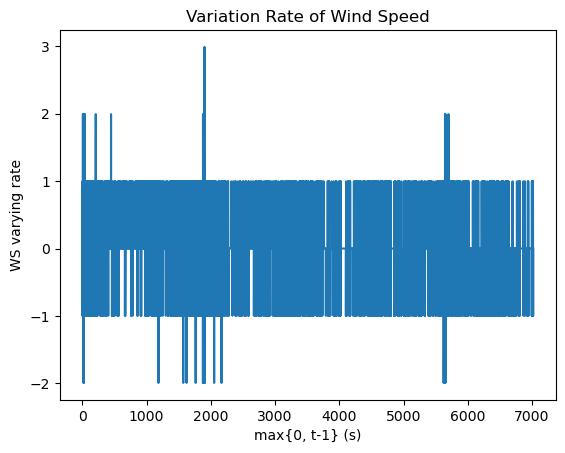

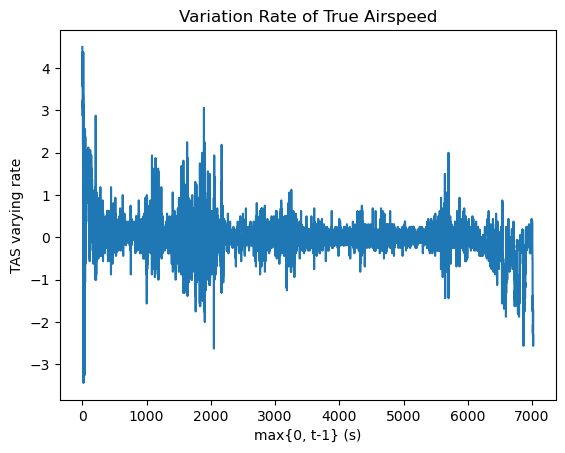

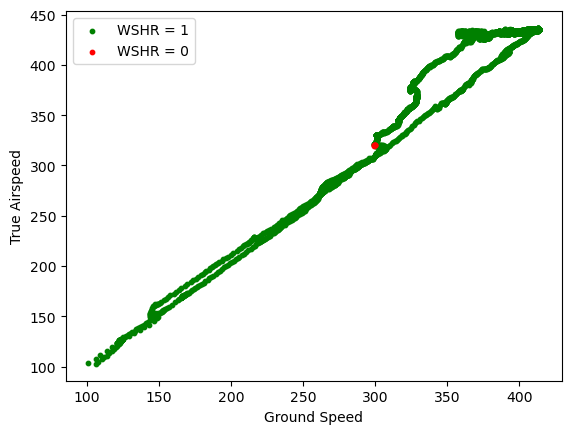

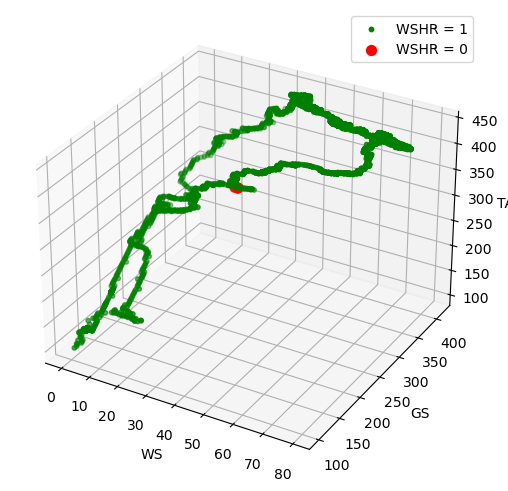

In [24]:
# 判据一：指示空速变化率不超过正负15节(7.7m/s)
'''
这里说明有些模糊，数据里空速顶在400多节，应该是按变化率来看
'''
variable_list = ['WS', 'GS', 'TAS']

# 构建数据集
X, Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2], variable_list, normalized=False)
# 读取聚类标签
cluster_labels = np.load('../result/variable_cluster/DBSCAN/cluster_labels_e[3][2].npy')
# 抽取训练集中的有效数据
X, Y = X[cluster_labels == 2-1], Y[cluster_labels == 2-1]
wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]

# 绘制X的时间变化
plt.figure(figsize=(5,5))
color_list = ['orange', 'green', 'blue', 'black', 'purple', 'pink']
for i, var_name in enumerate(variable_list):
    plt.plot(range(len(Y)), X[:, i], c=color_list[i], label=var_name)
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
plt.xlabel('time(s)')
plt.ylabel('WS/GS/TAS & WSHR')
plt.title('WS/GS/TAS and WSHR')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

# 绘制风速的时序差分图
WS_diff = X[1:, 0] - X[:-1, 0]
plt.figure()
plt.plot(range(len(WS_diff)), WS_diff)
plt.title('Variation Rate of Wind Speed')
plt.xlabel('max{0, t-1} (s)')
plt.ylabel('WS varying rate')
plt.show()

# 绘制空速的时序差分图
TAS_diff = X[1:, 2] - X[:-1, 2]
plt.figure()
plt.plot(range(len(TAS_diff)), TAS_diff)
plt.title('Variation Rate of True Airspeed')
plt.xlabel('max{0, t-1} (s)')
plt.ylabel('TAS varying rate')
plt.show()

# 绘制二维关联图
plt.figure()
plt.scatter(X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
plt.scatter(X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 10, label='WSHR = 0')
plt.xlabel('Ground Speed')
plt.ylabel('True Airspeed')
plt.legend()
plt.show()

# plt.figure()
# plt.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
# plt.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 2], c='red', s = 10, label='WSHR = 0')
# plt.xlabel('Wind Speed')
# plt.ylabel('True Airspeed')
# plt.legend()
# plt.show()

# plt.figure()
# plt.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], c='green', s = 10, label='WSHR = 1')
# plt.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], c='red', s = 10, label='WSHR = 0')
# plt.xlabel('Wind Speed')
# plt.ylabel('Ground Speed')
# plt.legend()
# plt.show()

# 绘制X的三维散点图
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 50, label='WSHR = 0')
ax.set_xlabel(variable_list[0])
ax.set_ylabel(variable_list[1])
ax.set_zlabel(variable_list[2])
ax.legend()
plt.tight_layout()
plt.show()

Wind Shear Warns at time [938 939 940 941 942 943]


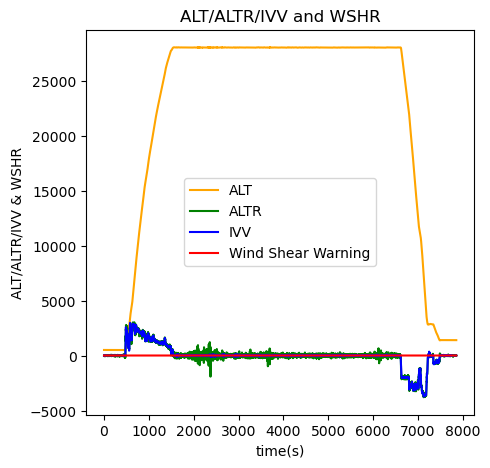

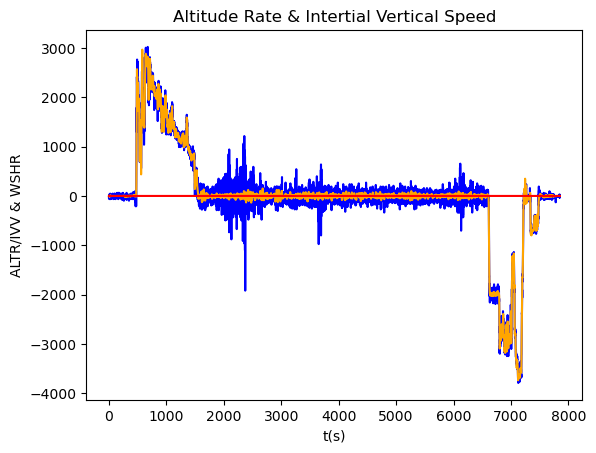

Altitute varying rate out of control at time: [ 479  480  481 ... 7468 7469 7470]


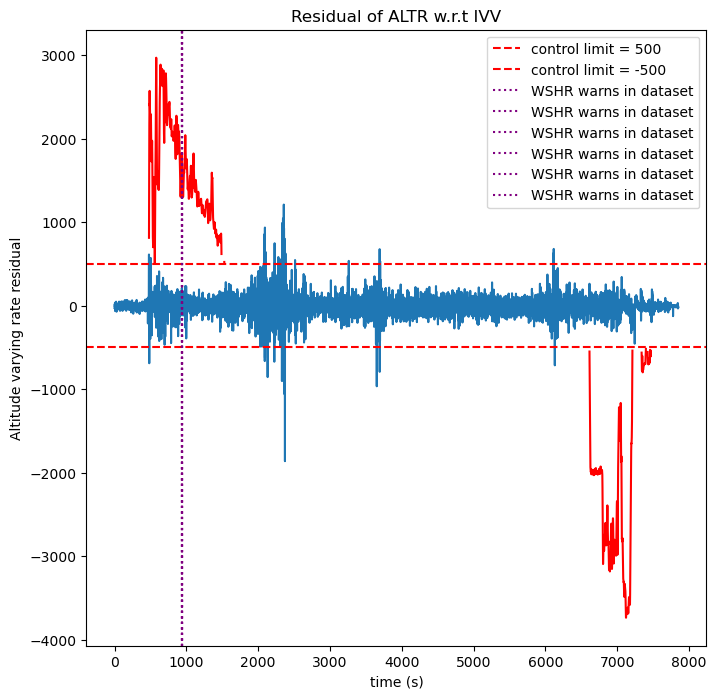

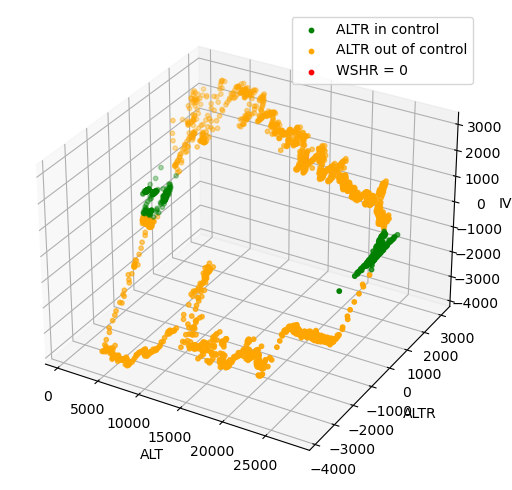

In [24]:
# 判据二：垂直升降率不超过500英尺/分钟 (152.4m)
'''
民航客机的巡航高度约为10000米（33000英尺），ALT和ALTR记录的量纲为英尺
ALTR实质是ALT的步差，这里用秒差，但是单位转化成了英尺/分钟（乘了60）
IVV是为了避免在近地复杂环境下、飞机垂直高度变化但根据静压计算的高度表不走、进而导致ALTR漂移的问题，
    采用惯性单元、计算重力加速度的变化积分、加以大气数据长期修正以综合计算出的垂直速度
    https://www.zhihu.com/question/595326371?write#:~:text=%E6%83%AF%E6%80%A7%E5%9E%82%E7%9B%B4%E9%80%9F%E5%BA%A6%20%E3%80%82%20%E4%B8%80%E8%88%AC%E7%9A%84%E5%9E%82%E7%9B%B4%E9%80%9F%E5%BA%A6%E6%98%AF%E5%A4%A7%E6%B0%94%E6%95%B0%E6%8D%AE%E8%AE%A1%E7%AE%97%E5%87%BA%E6%9D%A5%E7%9A%84%EF%BC%8C%E6%A0%B9%E6%8D%AE,%E9%9D%99%E5%8E%8B%20%E8%AE%A1%E7%AE%97%E9%AB%98%E5%BA%A6%EF%BC%8C%E7%84%B6%E5%90%8E%E6%A0%B9%E6%8D%AE%E9%AB%98%E5%BA%A6%E5%8F%98%E5%8C%96%E8%AE%A1%E7%AE%97%E5%9E%82%E7%9B%B4%E9%80%9F%E5%BA%A6%EF%BC%8C%E6%88%96%E8%80%85%E7%9B%B4%E6%8E%A5%E6%B5%8B%E9%87%8F%20%E9%9D%99%E5%8E%8B%E5%8F%98%E5%8C%96%E7%8E%87%20%E6%8D%A2%E7%AE%97%E3%80%82
'''

def ALTRmetrics(folder_name, mat_name, normalized=False):
    # 构建数据集
    variable_list = ['ALT', 'ALTR', 'IVV']
    X, Y = dataConstruct(folder_name, mat_name, variable_list)

    # 绘制X的时间变化
    plt.figure(figsize=(5,5))
    color_list = ['orange', 'green', 'blue', 'black', 'purple', 'pink']
    for i, var_name in enumerate(variable_list):
        plt.plot(range(len(Y)), X[:, i], c=color_list[i], label=var_name)
    plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
    plt.xlabel('time(s)')
    plt.ylabel('ALT/ALTR/IVV & WSHR')
    plt.title('ALT/ALTR/IVV and WSHR')
    plt.legend()
    # if np.std(X[:, 2]) > 1e-1:
    #     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
    plt.show()

    # ALT_diff = X[1:, 0] - X[:-1, 0]
    # plt.figure()
    # plt.plot(range(len(ALT_diff)), ALT_diff)
    # # plt.xlim(1100, 6000)
    # # plt.ylim(-100,100)
    # plt.title('Variation Rate of Altitude (in second)')
    # plt.xlabel('max{0, t-1} (s)')
    # plt.ylabel('Altitude varying rate')
    # plt.show()

    # # 以60s为滑动窗口，计算海拔的变化值
    # ALT_diff = X[60:, 0] - X[:-60, 0]
    # plt.figure()
    # plt.plot(range(len(ALT_diff)), ALT_diff)
    # # plt.xlim(1100, 6000)
    # # plt.ylim(-100,100)
    # plt.title('Variation Rate of Altitude (in minute)')
    # plt.xlabel('max{0, t-60} (s)')
    # plt.ylabel('Altitude varying rate')
    # plt.show()

    # # 比较ALTR和分钟滑动的ALT
    # '''
    # ALTR相当于在这一秒预测接下来一分钟的升降率（基于下一秒的步差），ALT分钟滑动相当于计算接下来一分钟实际发生的升降率
    # 前者反映瞬间的速度方向，后者反映一分钟内的平均位移水平（是计划上升还是巡航还是计划下降）
    # 二者的差分反映这一秒的升降率是否在计划内
    # 滑动的窗口大小实际上可以调节，但是考虑到单位是英尺/分钟，选取了1分钟做窗口
    # '''
    # ALT_diff_extend = [0 if i-60 < 0 else ALT_diff[i-60] for i in range(len(X[:, 1]))]
    # # ALT_diff_extend = [0 if i-1 < 0 else ALT_diff[i-1]*60 for i in range(len(X[:, 1]))]
    # ALTR_residual = np.array(ALT_diff_extend) - X[:, 1]
    # plt.figure()
    # plt.plot(range(len(X[:, 1])), X[:, 1], label='ALTR')
    # plt.plot(range(len(ALT_diff_extend)), ALT_diff_extend, label='ALT difference in minute')
    # # plt.plot(range(len(ALTR_residual)), ALTR_residual, label='ALTR residual w.r.t ALT min-differ')
    # plt.title('Variation Rate of Altitude Comparison')
    # plt.xlabel('time (s)')
    # plt.ylabel('Altitude varying rate')
    # plt.legend()
    # plt.show()

    # # 计算ALTR相较于分钟滑动ALT的残差
    # # ALT_stable_time = np.where(np.abs(ALT_diff) <= 30)[0]
    # ALT_stable_time = []
    # wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
    # # print(np.min(ALT_stable_time), np.max(ALT_stable_time))
    # ALTR_residual = np.array(ALT_diff_extend) - X[:, 1]
    # ALTR_overlimit = [ALTR_residual[i] if abs(ALTR_residual[i])>500 and i not in ALT_stable_time else None for i in range(len(ALTR_residual))]
    # ALTR_IC_idx_list = np.where(np.array(ALTR_overlimit) == None)[0]
    # ALTR_OOC_idx_list = np.where(np.array(ALTR_overlimit) != None)[0]
    # print(f"Altitute varying rate out of control at time: {ALTR_OOC_idx_list}")
    # plt.figure(figsize=(8, 8))
    # plt.plot(range(len(ALTR_residual)), ALTR_residual)
    # plt.scatter(range(len(ALTR_overlimit)), ALTR_overlimit, c='red', s=10)
    # for i, value in enumerate(ALTR_overlimit):
    #     if value != None:
    #         plt.axvline(x=i, ymin=np.min(ALTR_residual), ymax=np.min(ALTR_residual)+50, color='purple', linestyle='dotted')
    # plt.axhline(y=500, color='r', linestyle='--', label='control limit = 500') 
    # plt.axhline(y=-500, color='r', linestyle='--', label='control limit = -500') 
    # for t in wshr_class_idx[0]:
    #     plt.axvline(x=t, color = 'purple', linestyle='dotted', label='WSHR warns in dataset')
    # plt.title('Residual of ALTR w.r.t ALT min-difference')
    # plt.xlabel('time (s)')
    # plt.ylabel('Altitude varying rate residual')
    # plt.legend()
    # plt.show()

    # 具体展示ALTR和IVV
    plt.figure()
    plt.plot(range(len(Y)), X[:, 1], color='blue', label='Altitude Rate')
    plt.plot(range(len(Y)), X[:, 2], color='orange', label='Intertial Vertical Speed')
    plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
    plt.title('Altitude Rate & Intertial Vertical Speed')
    plt.xlabel('t(s)')
    plt.ylabel('ALTR/IVV & WSHR')
    plt.show()

    # 计算ALTR和IVV的差
    '''
    这个算出来的是ALTR相较于IVV的漂移量，但我需要垂直升降率也就是垂直速度
    '''
    ALTR_residual = X[:, 1] - X[:, 2]
    ALT_stable_time = []
    wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
    # ALTR_overlimit = [ALTR_residual[i] if abs(ALTR_residual[i])>500 and i not in ALT_stable_time else None for i in range(len(ALTR_residual))]
    ALTR_overlimit = [X[i, 2] if abs(X[i, 2])>500 and i not in ALT_stable_time else None for i in range(len(X[:, 2]))]
    ALTR_IC_idx_list = np.where(np.array(ALTR_overlimit) == None)[0]
    ALTR_OOC_idx_list = np.where(np.array(ALTR_overlimit) != None)[0]
    print(f"Altitute varying rate out of control at time: {ALTR_OOC_idx_list}")
    plt.figure(figsize=(8, 8))
    plt.plot(range(len(ALTR_residual)), ALTR_residual)
    plt.plot(range(len(ALTR_overlimit)), ALTR_overlimit, c='red')
    for i, value in enumerate(ALTR_overlimit):
        if value != None:
            plt.axvline(x=i, ymin=np.min(ALTR_residual), ymax=np.min(ALTR_residual)+50, color='purple', linestyle='dotted')
    plt.axhline(y=500, color='r', linestyle='--', label='control limit = 500') 
    plt.axhline(y=-500, color='r', linestyle='--', label='control limit = -500') 
    for t in wshr_class_idx[0]:
        plt.axvline(x=t, color = 'purple', linestyle='dotted', label='WSHR warns in dataset')
    plt.title('Residual of ALTR w.r.t IVV')
    plt.xlabel('time (s)')
    plt.ylabel('Altitude varying rate residual')
    plt.legend()
    plt.show()


    # 绘制X的三维散点图
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[ALTR_IC_idx_list, 0], X[ALTR_IC_idx_list, 1], X[ALTR_IC_idx_list, 2], c='green', s = 10, label='ALTR in control')
    ax.scatter(X[ALTR_OOC_idx_list, 0], X[ALTR_OOC_idx_list, 1], X[ALTR_OOC_idx_list, 2], c='orange', s = 10, label='ALTR out of control')
    ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 10, label = 'WSHR = 0')
    ax.set_xlabel(variable_list[0])
    ax.set_ylabel(variable_list[1])
    ax.set_zlabel(variable_list[2])
    ax.legend()
    plt.tight_layout()
    plt.show()

    return ALTR_OOC_idx_list

# 构建数据集
for mat_idx in [2, 8]:
    # X, Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[mat_idx], variable_list, normalized=False)
    # # 读取聚类标签
    # cluster_labels = np.load('../result/variable_cluster/DBSCAN/cluster_labels_e[3][2].npy')
    # # 抽取训练集中的有效数据
    # X, Y = X[cluster_labels == 2-1], Y[cluster_labels == 2-1]
    ALTR_OOC_idx_list = ALTRmetrics(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[mat_idx])
    break


Wind Shear Warns at time [938 939 940 941 942 943]


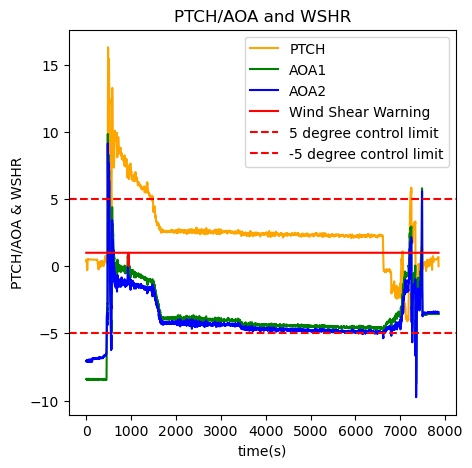

Pitch angle out of control at time [ 476  477  478 ... 7243 7244 7245]


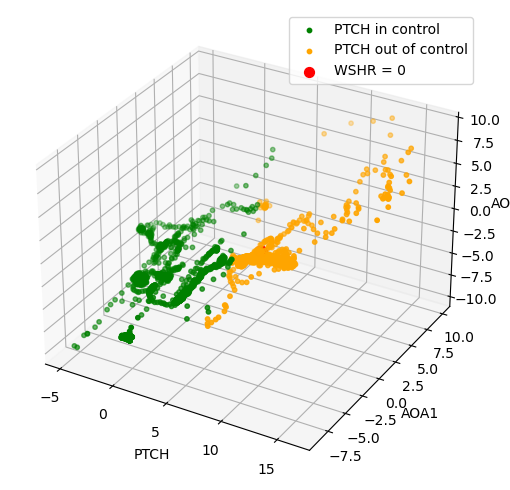

In [25]:
# 判据三：俯仰姿态(PTCH) = 迎角(AOA) + 轨迹角，绝对值不超过5度
'''
5度的俯仰姿态变化率有点太恐怖了，俯仰姿态不超出正负5度还说得过去，毕竟改出风切变里就有一条是增大俯仰姿态获得升力
15度是风切变改出角度，需要查明飞机正常起飞或降落时是否会有一段较大的俯仰姿态
TH, TRK, TRKM可以视为一族变量，趋势极度相似。并不像是民航标准里的flight path angle，应该是“俯视飞机”的视角下的“前进方向角”
AOA1和AOA2能否做平均？
'''

def PTCHmetrics(folder_name, mat_name, normalized=False):
    # 构建数据集
    variable_list = ['PTCH', 'AOA1', 'AOA2', 'TH'] 
    X, Y = dataConstruct(folder_name, mat_name, variable_list, normalized)
    # 绘制X的时间变化
    plt.figure(figsize=(5,5))
    color_list = ['orange', 'green', 'blue', 'black', 'purple', 'pink']
    for i, var_name in enumerate(variable_list):
        if i < len(variable_list) - 1:
            plt.plot(range(len(Y)), X[:, i], c=color_list[i], label=var_name)
    plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
    plt.axhline(y=5, c='r', linestyle='--', label='5 degree control limit')
    plt.axhline(y=-5, c='r', linestyle='--', label='-5 degree control limit')
    plt.xlabel('time(s)')
    plt.ylabel('PTCH/AOA & WSHR')
    plt.title('PTCH/AOA and WSHR')
    plt.legend()
    # if np.std(X[:, 2]) > 1e-1:
    #     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
    plt.show()

    # 打印俯仰姿态绝对值超过5度的时刻
    PTCH_IC_idx_list = np.where(np.abs(X[:, 0]) <= 5)[0]
    PTCH_OOC_idx_list = np.where(np.abs(X[:, 0]) > 5)[0]
    print(f"Pitch angle out of control at time {PTCH_OOC_idx_list}")

    # # 绘制俯仰姿态的时序差分图
    # PTCH_diff = X[1:, 0] - X[:-1, 0]
    # plt.figure()
    # plt.plot(range(len(PTCH_diff)), PTCH_diff)
    # plt.title('Variation Rate of Pitch Angle')
    # plt.xlabel('max{0, t-1} (s)')
    # plt.ylabel('PTCH varying rate')
    # plt.show()

    # 绘制X的三维散点图
    wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
    ax.scatter(X[PTCH_IC_idx_list, 0], X[PTCH_IC_idx_list, 1], X[PTCH_IC_idx_list, 2], c='green', s = 10, label='PTCH in control')
    ax.scatter(X[PTCH_OOC_idx_list, 0], X[PTCH_OOC_idx_list, 1], X[PTCH_OOC_idx_list, 2], c='orange', s = 10, label='PTCH out of control')
    ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 50, label='WSHR = 0')
    ax.set_xlabel(variable_list[0])
    ax.set_ylabel(variable_list[1])
    ax.set_zlabel(variable_list[2])
    ax.legend()
    plt.tight_layout()
    plt.show()

    return PTCH_OOC_idx_list

    # # 拟合俯仰姿态的计算公式
    # import numpy as np
    # from scipy import stats

    # # 使用 linregress 函数进行线性拟合
    # slope, residuals, _, _ = np.linalg.lstsq(X[:, 1:], X[:, 0].reshape(-1,1))

    # # 打印拟合的结果
    # print("斜率:", slope)
    # print("残差:", residuals)

# # 构建数据集
# X, Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2], variable_list, normalized=False)
# X, Y = dataConstruct(download_folder_paths[0], os.listdir(download_folder_paths[0])[6], variable_list, normalized=False)
# # 读取聚类标签
# cluster_labels = np.load('../result/variable_cluster/DBSCAN/cluster_labels_e[3][2].npy')
# # 抽取训练集中的有效数据
# X, Y = X[cluster_labels == 2-1], Y[cluster_labels == 2-1]
# X, Y = X[cluster_labels == 3-1], Y[cluster_labels == 3-1]
PTCH_OOC_idx_list = PTCHmetrics(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2])

Wind Shear Warns at time [938 939 940 941 942 943]


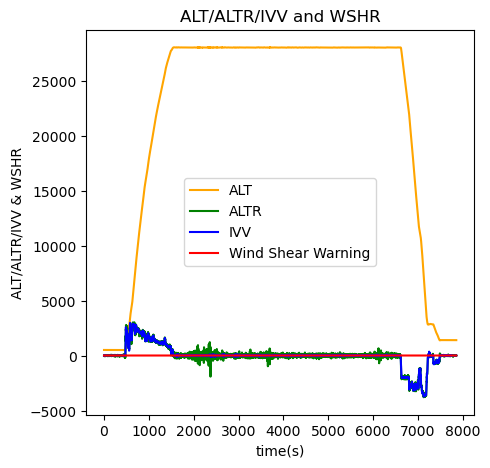

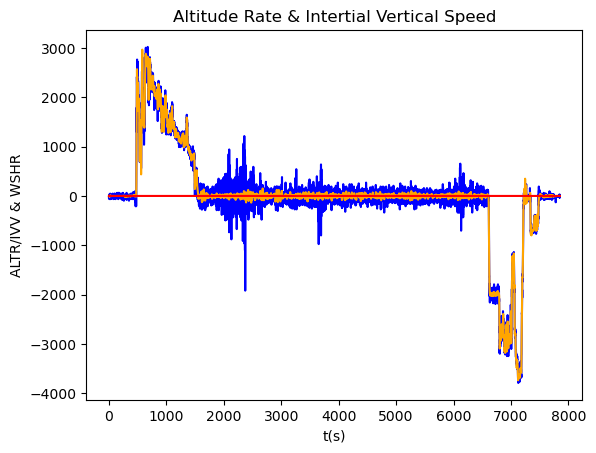

Altitute varying rate out of control at time: [ 479  480  481 ... 7468 7469 7470]


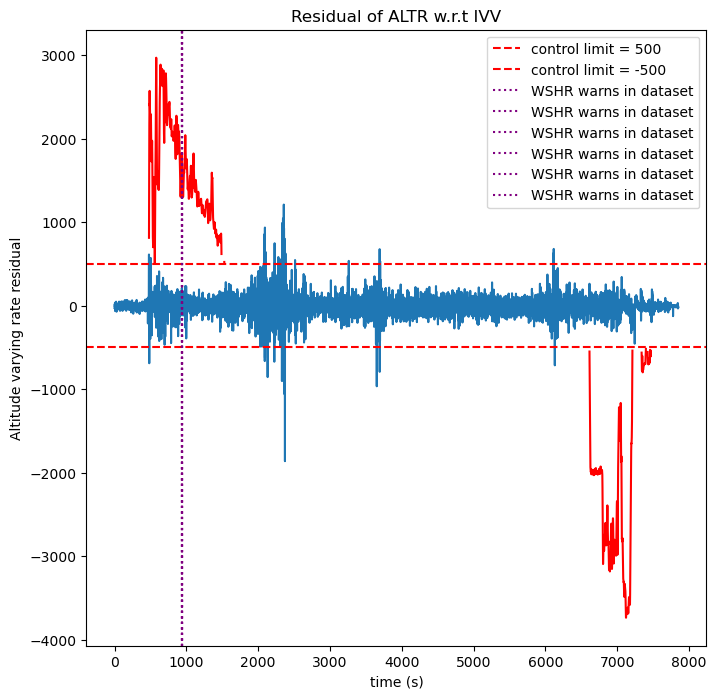

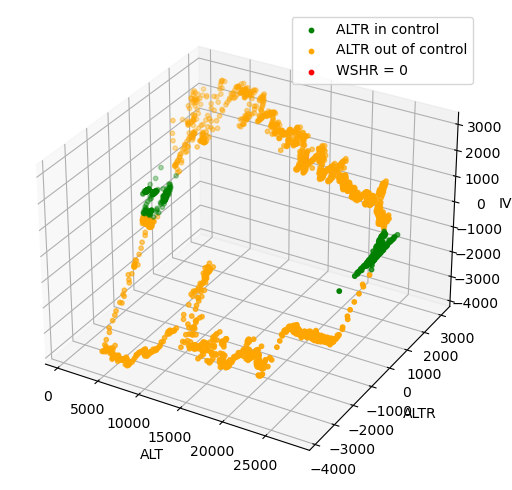

Wind Shear Warns at time [938 939 940 941 942 943]


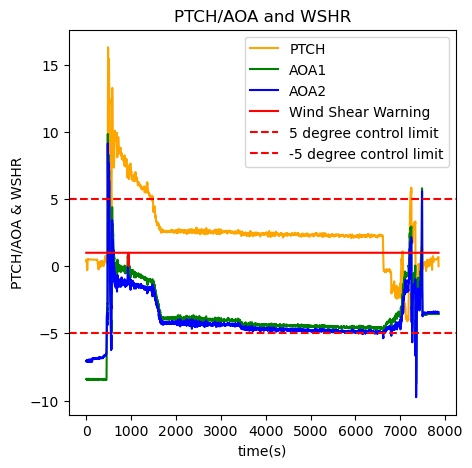

Pitch angle out of control at time [ 476  477  478 ... 7243 7244 7245]


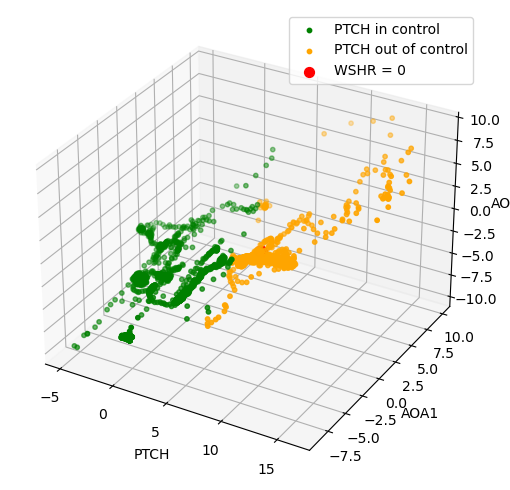

Wind Shear Warns at time [938 939 940 941 942 943]
Possible WSHR time: [ 479  480  481  482  483  484  485  486  487  488  489  490  491  492
  493  494  495  496  497  498  499  500  501  502  503  504  505  506
  507  508  509  510  511  512  513  514  515  516  517  518  519  520
  521  522  523  524  525  526  527  528  529  530  531  532  533  534
  535  536  537  538  539  540  541  542  543  544  545  546  547  548
  549  550  551  552  553  554  555  563  564  565  566  567  568  569
  570  571  572  573  574  575  576  577  578  579  580  581  582  583
  584  585  586  587  588  589  590  591  592  593  594  595  596  597
  598  599  600  601  602  603  604  605  606  607  608  609  610  611
  612  613  614  615  616  617  618  619  620  621  622  623  624  625
  626  627  628  629  630  631  632  633  634  635  636  637  638  639
  640  641  642  643  644  645  646  647  648  649  650  651  652  653
  654  655  656  657  658  659  660  661  662  663  664  665  666  667
  668 

d:\coding\Anaconda\Software\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[-1  0  0  1 -1  2  2 -1  2  2  2  2  2  2  2  2  2  2  3  2  2  2  2  3
  2  2  2  2  2  2  2  1 -1  4  4  4  4  4  4  4  4  4 -1  4  4  4 -1  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6 -1  7 -1  8  8  8  8  8
  8  7 -1  6  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5

C:\Users\86108\AppData\Local\Temp\ipykernel_57848\691630352.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(f'Cluster {i}: {np.where(X[:, :-1] == X_cross[db_labels == i])}')


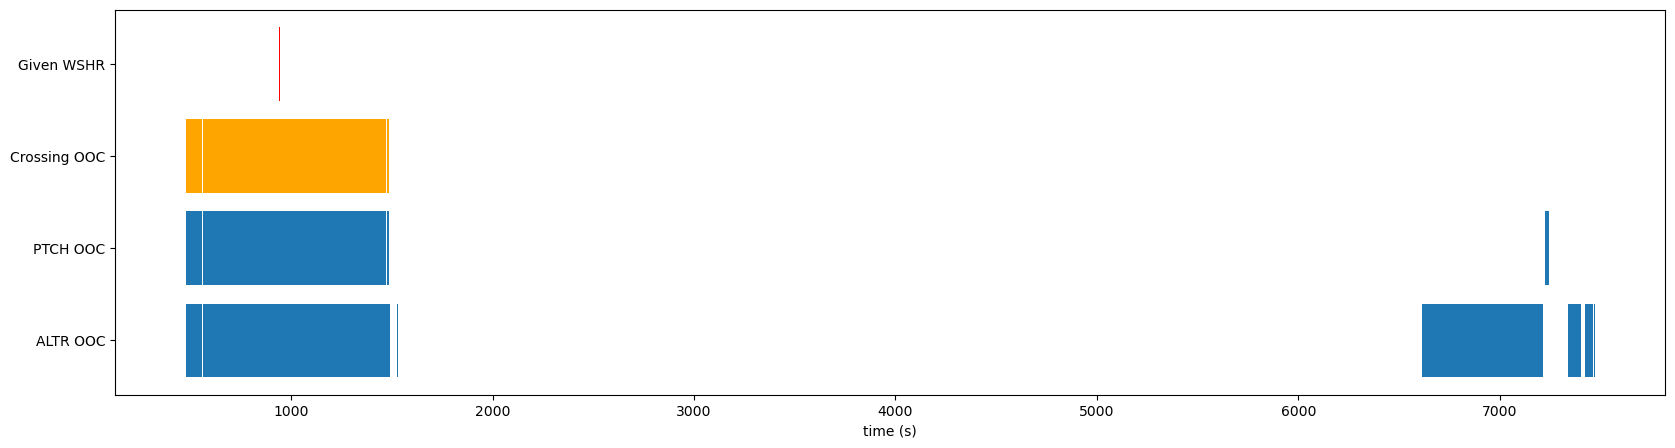

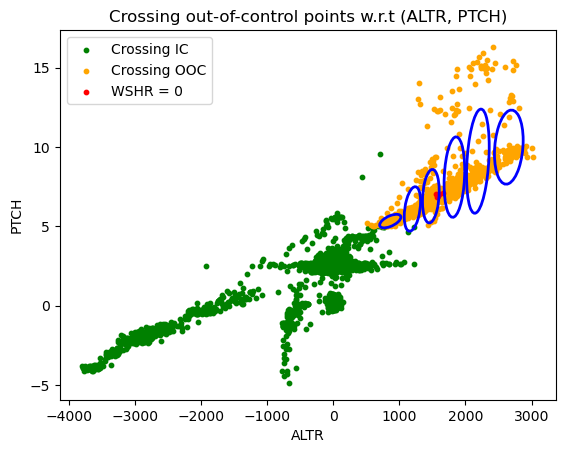

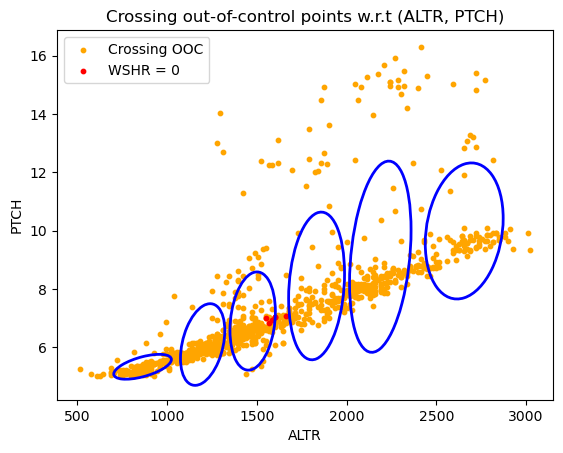

C:\Users\86108\AppData\Local\Temp\ipykernel_57848\691630352.py:90: RuntimeWarning: invalid value encountered in sqrt
  width, height = 3 * np.sqrt(eigenvalues)
d:\coding\Anaconda\Software\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\coding\Anaconda\Software\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\86108\AppData\Local\Temp\ipykernel_57848\691630352.py:87: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariances = np.cov(X_cross[db_labels == i].T)
d:\coding\Anaconda\Software\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\coding\Anaconda\Software\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\coding\Anaconda\Software\lib\site-packages

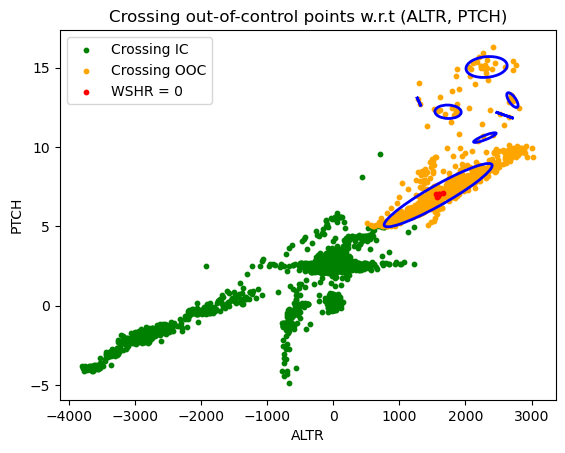

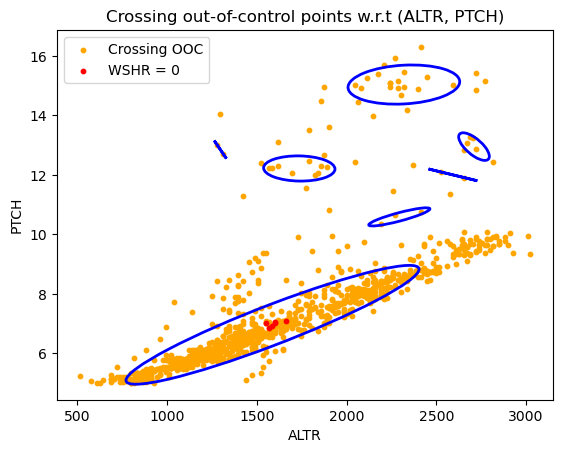

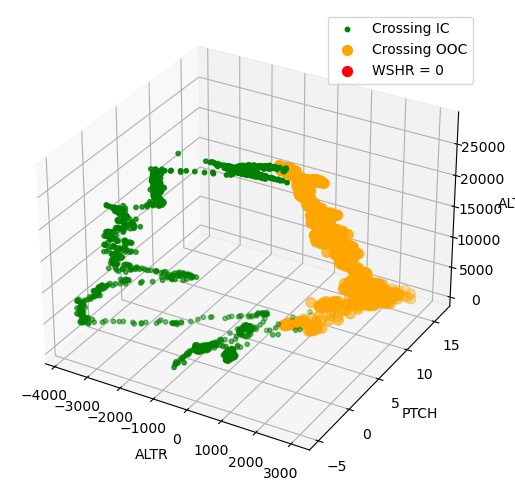

In [26]:
# ALTR判据与PTCH判据的交叉验证
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse

variable_list = ['ALTR', 'PTCH', "ALT"]
'''
考虑把包括WS、WD、TAS等全拿进来做一下
'''

# 构建数据集
# work_folder_path, work_mat_name = download_folder_paths[0], os.listdir(download_folder_paths[0])[6]
work_folder_path, work_mat_name = exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2]
ALTR_OOC_idx_list = ALTRmetrics(work_folder_path, work_mat_name)
PTCH_OOC_idx_list = PTCHmetrics(work_folder_path, work_mat_name)
# X, Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2], variable_list, normalized=False)
X, Y = dataConstruct(work_folder_path, work_mat_name, variable_list, normalized=False)
wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]

# 获取两判据OOC的交集
cross_OOC_idx_list = np.sort(list(set(ALTR_OOC_idx_list) & set(PTCH_OOC_idx_list)))
cross_IC_idx_list = [time for time in range(len(Y)) if time not in cross_OOC_idx_list]
print(f'Possible WSHR time: {cross_OOC_idx_list}')

# 裁取交叉判定可能存在异常的(ALTR, PTCH)的数据集
X_cross = X[cross_OOC_idx_list, :-1]
X_cross_scaled = StandardScaler().fit_transform(X_cross)

# 对于crossing的(ALTR, PTCH)进行K-means++聚类
kmeans =  KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_cross)
kmeans_centers = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_

# 对于crossing的(ALTR, PTCH)进行DBSCAN聚类
db = DBSCAN(eps=0.3, min_samples=2).fit(X_cross_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
db_labels = db.labels_
print(db_labels)
for i in np.unique(db_labels):
    print(f'Cluster {i}: {np.where(X[:, :-1] == X_cross[db_labels == i])}')

# 绘制甘特图
fig, ax = plt.subplots(figsize=(20, 5))
ax.broken_barh([(time, 1) for time in ALTR_OOC_idx_list], (0-0.4, 0.8), label='ALTR out of control')
ax.broken_barh([(time, 1) for time in PTCH_OOC_idx_list], (1-0.4, 0.8), label='PTCH out of control')
ax.broken_barh([(time, 1) for time in cross_OOC_idx_list], (2-0.4, 0.8), facecolors = 'orange', label='Crossing OOC time')
ax.broken_barh([(time, 1) for time in wshr_class_idx[0]], (3-0.4, 0.8), facecolors = 'red', label='Given WSHR time')
ax.set_yticks(range(4))
ax.set_yticklabels(['ALTR OOC', "PTCH OOC", 'Crossing OOC', 'Given WSHR'])
plt.xlabel('time (s)')
plt.show()

# 绘制ALTR和PTCH的散点图及kmneas聚类椭圆形式图
for i in range(2):
    plt.figure()
    if i == 0:
        plt.scatter(X[cross_IC_idx_list, 0], X[cross_IC_idx_list, 1], c='green', s = 10, label='Crossing IC')
    plt.scatter(X[cross_OOC_idx_list, 0], X[cross_OOC_idx_list, 1], c='orange', s = 10, label='Crossing OOC')
    plt.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], c='red', s = 10, label='WSHR = 0')
    for i in range(len(kmeans_centers)):
        covariances = np.cov(X_cross[kmeans_labels == i].T)
        eigenvalues, eigenvectors = np.linalg.eigh(covariances)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        width, height = 3 * np.sqrt(eigenvalues)
        ell = Ellipse(xy=kmeans_centers[i], width=width, height=height, angle=angle, edgecolor='blue', lw=2, facecolor='none')
        plt.gca().add_patch(ell)
    plt.xlabel(variable_list[0])
    plt.ylabel(variable_list[1])
    if i == 0:
        plt.title('Crossing in-control & out-of-control points w.r.t (ALTR, PTCH)')
    else:
        plt.title('Crossing out-of-control points w.r.t (ALTR, PTCH)')
    plt.legend()
    plt.show()

# 绘制ALTR和PTCH的散点图及DBSCAN聚类椭圆形式图
for i in range(2):
    plt.figure()
    if i == 0:
        plt.scatter(X[cross_IC_idx_list, 0], X[cross_IC_idx_list, 1], c='green', s = 10, label='Crossing IC')
    plt.scatter(X[cross_OOC_idx_list, 0], X[cross_OOC_idx_list, 1], c='orange', s = 10, label='Crossing OOC')
    plt.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], c='red', s = 10, label='WSHR = 0')
    for i in range(len(np.unique(db_labels))):
        covariances = np.cov(X_cross[db_labels == i].T)
        eigenvalues, eigenvectors = np.linalg.eigh(covariances)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        width, height = 3 * np.sqrt(eigenvalues)
        ell = Ellipse(xy=np.mean(X_cross[db_labels == i], axis=0), width=width, height=height, angle=angle, edgecolor='blue', lw=2, facecolor='none')
        plt.gca().add_patch(ell)
    plt.xlabel(variable_list[0])
    plt.ylabel(variable_list[1])
    if i == 0:
        plt.title('Crossing in-control & out-of-control points w.r.t (ALTR, PTCH)')
    else:
        plt.title('Crossing out-of-control points w.r.t (ALTR, PTCH)')
    plt.legend()
    plt.show()

# 绘制三维散点图
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
ax.scatter(X[cross_IC_idx_list, 0], X[cross_IC_idx_list, 1], X[cross_IC_idx_list, 2], c='green', s = 10, label='Crossing IC')
ax.scatter(X[cross_OOC_idx_list, 0], X[cross_OOC_idx_list, 1], X[cross_OOC_idx_list, 2], c='orange', s = 50, label = 'Crossing OOC')
# ax.scatter(X[ALTR_OOC_idx_list, 0], X[ALTR_OOC_idx_list, 1], X[ALTR_OOC_idx_list, 2], c='pink', s = 10, label='ALTR out of control')
# ax.scatter(X[PTCH_OOC_idx_list, 0], X[PTCH_OOC_idx_list, 1], X[PTCH_OOC_idx_list, 2], c='blue', s = 10, label='PTCH out of control')
ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 50, label='WSHR = 0')
ax.set_xlabel(variable_list[0])
ax.set_ylabel(variable_list[1])
ax.set_zlabel(variable_list[2])
ax.legend()
plt.tight_layout()
plt.show()

Wind Shear Warns at time [938 939 940 941 942 943]


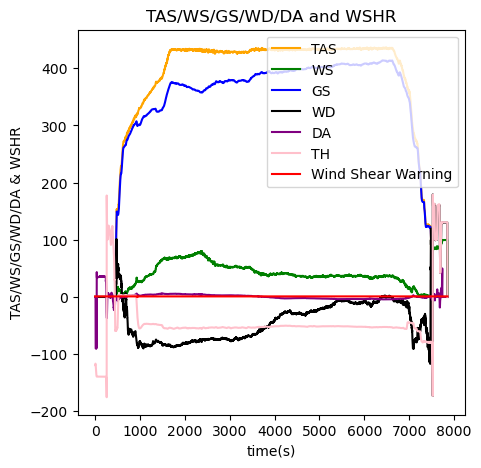

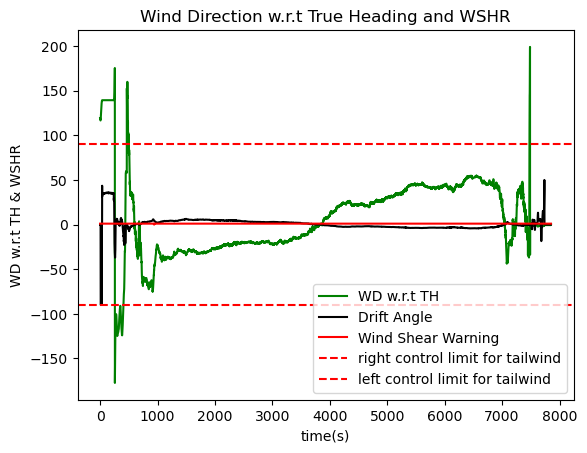

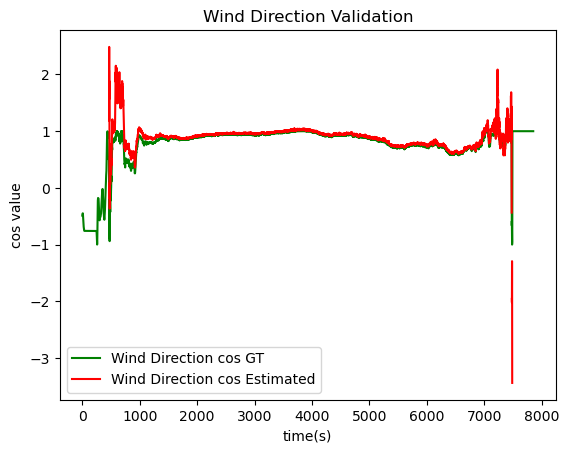

In [58]:
# 验证航行速度三角形
variable_list = ['TAS', 'WS', 'GS', 'WD', 'DA', 'TH']

X, Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2], variable_list, normalized=False)

# 绘制X的时间变化
plt.figure(figsize=(5,5))
color_list = ['orange', 'green', 'blue', 'black', 'purple', 'pink']
for i, var_name in enumerate(variable_list):
    plt.plot(range(len(Y)), X[:, i], c=color_list[i], label=var_name)
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
# plt.ylim(-100, 100)
plt.xlabel('time(s)')
plt.ylabel('TAS/WS/GS/WD/DA/TH & WSHR')
plt.title('TAS/WS/GS/WD/DA/TH and WSHR')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

# 计算WD相对于TH坐标系的角度，以判断逆风/顺风
'''
航行速度三角形是成立的，但是TAS和TH的坐标系是以磁北为极轴的极坐标系，而WS和WD的坐标系是以磁南为极轴的极坐标系
DA值很小且符号一般与WD-TH相反，因此DA大概率是以磁东作为极轴且以顺时针为正方向。
DA是偏流角的方向以航向为基准，顺时针转向航迹为正，逆时针转向航迹为负。
'''
# WD_wrtTH = 180 - (X[:, 3] - X[:, 5])
WD_wrtTH = X[:, 3] - X[:, 5]
plt.figure()
plt.plot(range(len(Y)), WD_wrtTH, c='green', label='WD w.r.t TH')
plt.plot(range(len(Y)), X[:, 4], c='black', label='Drift Angle')
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
plt.axhline(y=90, c='r', linestyle='--', label='right control limit for tailwind')
plt.axhline(y=-90, c='r', linestyle='--', label='left control limit for tailwind')
# plt.xlim(900, 950)
plt.xlabel('time(s)')
plt.ylabel('WD w.r.t TH & WSHR')
plt.title('Wind Direction w.r.t True Heading and WSHR')
plt.legend()
plt.show()

# 余弦定理验证航行速度三角形
cos_WD, cos_WD_estimate = [], []
for i in range(len(Y)):
    cos_WD.append(np.cos(WD_wrtTH[i] * np.pi / 180))
    if X[i, 0] * X[i, 1] == 0:
        cos_WD_estimate.append(None)
    else:
        cos_WD_estimate.append( (X[i, 0]**2 + X[i, 1]**2 - X[i, 2]**2) / (2 * X[i, 0] * X[i, 1]))
plt.figure()
plt.plot(range(len(Y)), cos_WD, c='green', label='Wind Direction cos GT')
plt.plot(range(len(Y)), cos_WD_estimate, c='red', label='Wind Direction cos Estimated')
plt.xlabel('time(s)')
plt.ylabel('cos value')
plt.title('Wind Direction Validation')
plt.legend()
plt.show()

# # 正弦定理，验证DA的坐标系
# ratio_WS_DA, ratio_GS_WD = [], []
# for i in range(len(Y)):
#     if X[i, 4] == 0:
#         ratio_WS_DA.append(None)
#     else:
#         ratio_WS_DA.append(min(X[i, 1] / np.sin(X[i, 4]), 100))
# for i in range(len(Y)):
#     if cos_WD_estimate[i] == None:
#         ratio_GS_WD.append(None)
#     else:
#         ratio_GS_WD.append(min(X[i, 2] / np.sin(np.arccos(-cos_WD_estimate[i])), 100))
# plt.figure()
# plt.plot(range(len(Y)), ratio_WS_DA, c='green', label='ratio_WS_DA')
# plt.plot(range(len(Y)), ratio_GS_WD, c='red', label='ratio_GS_WD')
# plt.xlabel('time(s)')
# plt.ylabel('sin ratio')
# plt.title('DA Validation')
# plt.legend()
# plt.show()

Wind Shear Warns at time [938 939 940 941 942 943]


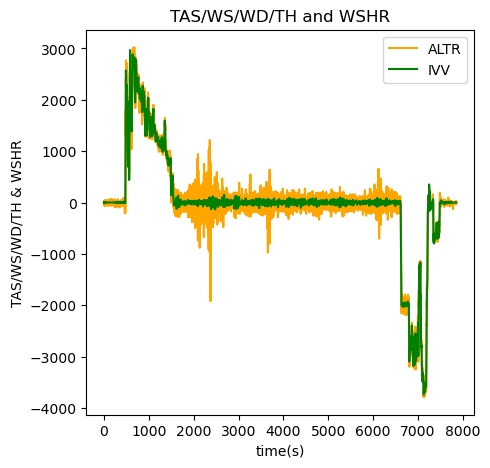

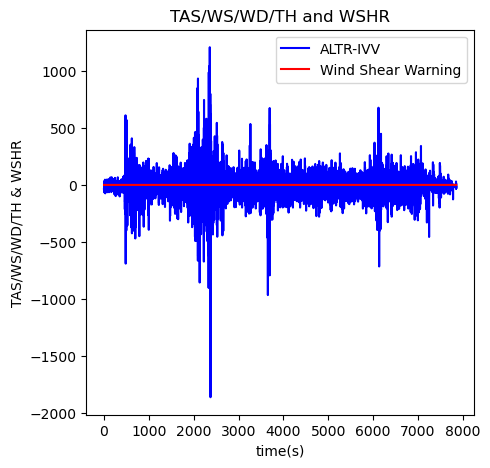

In [16]:
# 寻找垂向风速的计算方法
'''
IVV: Intertial vertical speed 惯性垂向速度
VRTG: Vertical accelaration
VSPS: Selected vertical speed
'''

variable_list = ['IVV', 'VRTG', 'VSPS', 'WD', 'WS', 'TH']
variable_list = ['ALTR', 'IVV']

X, Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2], variable_list, normalized=False)

# 绘制X的时间变化
plt.figure(figsize=(5,5))
color_list = ['orange', 'green', 'blue', 'black', 'purple', 'pink']
for i, var_name in enumerate(variable_list):
    plt.plot(range(len(Y)), X[:, i], c=color_list[i], label=var_name)
# plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
# plt.ylim(-100, 100)
plt.xlabel('time(s)')
plt.ylabel('TAS/WS/WD/TH & WSHR')
plt.title('TAS/WS/WD/TH and WSHR')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

# 计算ALTR和IVV的差值
diff_ALTR_IVV_list = X[:, 0] - X[:, 1]
plt.figure(figsize=(5,5))
color_list = ['orange', 'green', 'blue', 'black', 'purple', 'pink']
plt.plot(range(len(Y)), diff_ALTR_IVV_list, c='blue', label='ALTR-IVV')
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
# plt.ylim(-100, 100)
plt.xlabel('time(s)')
plt.ylabel('TAS/WS/WD/TH & WSHR')
plt.title('TAS/WS/WD/TH and WSHR')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

Wind Shear Warns at time [938 939 940 941 942 943]


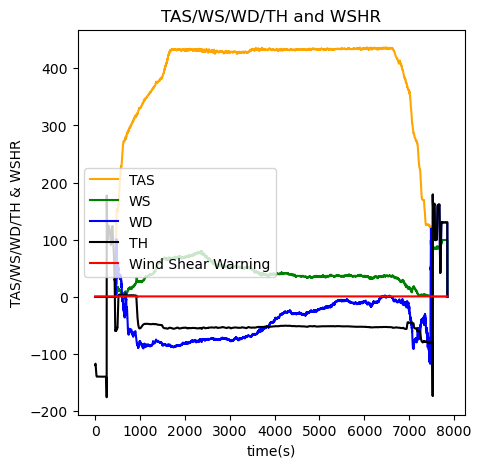

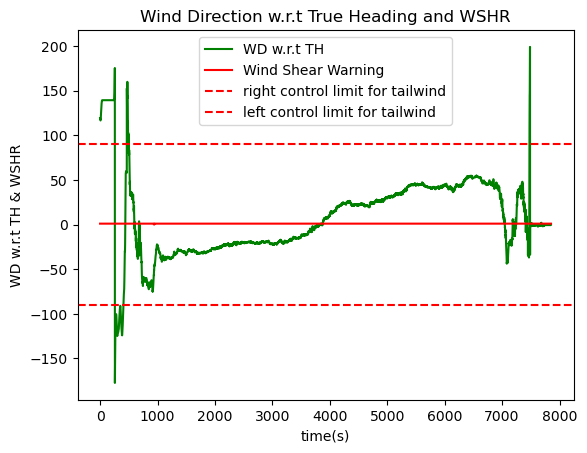

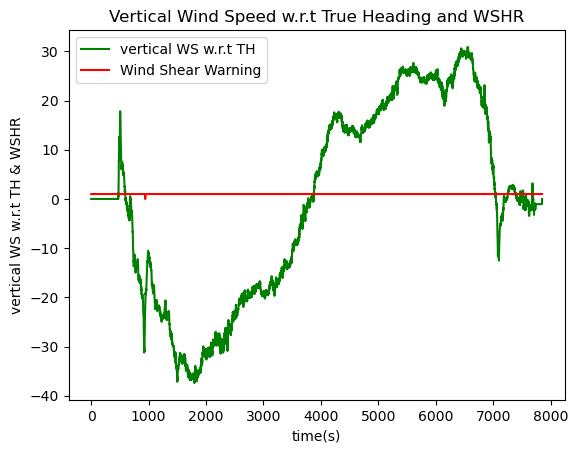

C:\Users\86108\AppData\Local\Temp\ipykernel_95952\3236688995.py:58: RuntimeWarning: invalid value encountered in double_scalars
  F_factor_b_half = np.array([vWS_wrtTH[i] / X[i, 0] for i in range(len(Y))])
C:\Users\86108\AppData\Local\Temp\ipykernel_95952\3236688995.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  F_factor_b_half = np.array([vWS_wrtTH[i] / X[i, 0] for i in range(len(Y))])


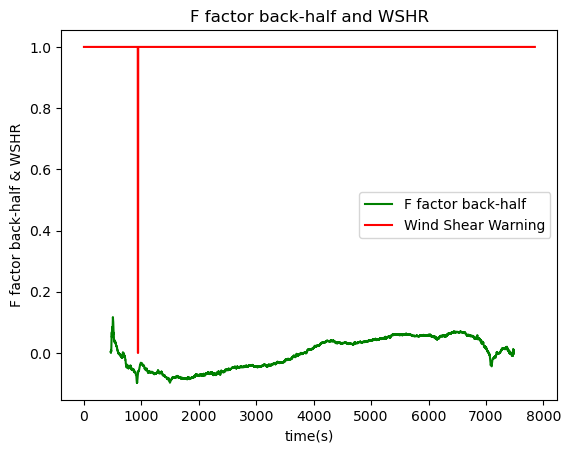

C:\Users\86108\AppData\Local\Temp\ipykernel_95952\3236688995.py:70: RuntimeWarning: invalid value encountered in subtract
  F_factor_b_half_diff = (F_factor_b_half[1:] - F_factor_b_half[:-1])*100


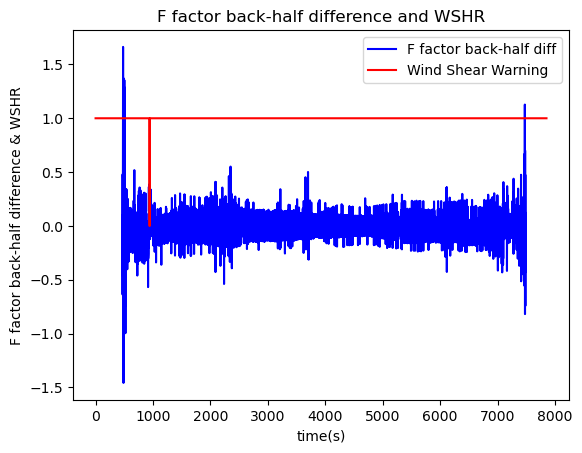

In [70]:
# F-factor 指标
'''
F-factor = 水平风变化率/重力加速度 + 垂直风速/空速
'''
variable_list = ['TAS', 'WS', 'WD', 'TH']

X, Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2], variable_list, normalized=False)

# 绘制X的时间变化
plt.figure(figsize=(5,5))
color_list = ['orange', 'green', 'blue', 'black', 'purple', 'pink']
for i, var_name in enumerate(variable_list):
    plt.plot(range(len(Y)), X[:, i], c=color_list[i], label=var_name)
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
# plt.ylim(-100, 100)
plt.xlabel('time(s)')
plt.ylabel('TAS/WS/WD/TH & WSHR')
plt.title('TAS/WS/WD/TH and WSHR')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

# 计算WD相对于TH坐标系的角度，以判断逆风/顺风
'''
航行速度三角形是成立的，但是TAS和TH的坐标系是以磁北为极轴的极坐标系，而WS和WD的坐标系是以磁南为极轴的极坐标系
DA值很小且符号一般与WD-TH相反，因此DA大概率是以磁东作为极轴且以顺时针为正方向。
DA是偏流角的方向以航向为基准，顺时针转向航迹为正，逆时针转向航迹为负。
'''
# WD_wrtTH = 180 - (X[:, 3] - X[:, 5])
WD_wrtTH = X[:, 2] - X[:, 3]
plt.figure()
plt.plot(range(len(Y)), WD_wrtTH, c='green', label='WD w.r.t TH')
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
plt.axhline(y=90, c='r', linestyle='--', label='right control limit for tailwind')
plt.axhline(y=-90, c='r', linestyle='--', label='left control limit for tailwind')
# plt.xlim(900, 950)
plt.xlabel('time(s)')
plt.ylabel('WD w.r.t TH & WSHR')
plt.title('Wind Direction w.r.t True Heading and WSHR')
plt.legend()
plt.show()

# 计算垂直风速
vWS_wrtTH = [np.sin(WD_wrtTH[i] * np.pi / 180) * X[:, 1][i] for i in range(len(Y))]
plt.figure()
plt.plot(range(len(Y)), vWS_wrtTH, c='green', label='vertical WS w.r.t TH')
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
# plt.xlim(900, 950)
plt.xlabel('time(s)')
plt.ylabel('vertical WS w.r.t TH & WSHR')
plt.title('Vertical Wind Speed w.r.t True Heading and WSHR')
plt.legend()
plt.show()

# 计算F-factor后半部分
F_factor_b_half = np.array([vWS_wrtTH[i] / X[i, 0] for i in range(len(Y))])
plt.figure()
plt.plot(range(len(Y)), F_factor_b_half, c='green', label='F factor back-half')
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
# plt.xlim(900, 950)
plt.xlabel('time(s)')
plt.ylabel('F factor back-half & WSHR')
plt.title('F factor back-half and WSHR')
plt.legend()
plt.show()

# 计算F-factor后半部分的梯度
F_factor_b_half_diff = (F_factor_b_half[1:] - F_factor_b_half[:-1])*100
F_factor_b_half_diff = np.insert(F_factor_b_half_diff, 0, 0)
plt.figure()
plt.plot(range(len(Y)), F_factor_b_half_diff, c='blue', label='F factor back-half diff')
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
# plt.xlim(900, 950)
plt.xlabel('time(s)')
plt.ylabel('F factor back-half difference & WSHR')
plt.title('F factor back-half difference and WSHR')
plt.legend()
plt.show()
